## Homework 4: Transporation mode choice modeling

Transportation planning and assessments are important aspects of modeling urban systems and are critical in making key decisions and shaping/estimating the commute behavior of urban population.

Here we demonstrate a framework for transporation mode choice modeling using Bayesian inference. Essentially, we want to model commute across the city by estimating mode choices between origin-destination taxi zone pairs in New York City among 4 available modes - transit, taxi, walking and driving.

In [1]:
# recommended in work in python 3.8
import pandas as pd
import numpy as np
from numpy import inf
from scipy.stats import norm
import itertools
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

We use data from primarily two sources:
- the travel duration and fare cost for taxi, transit and driving modes are extracted from Google Maps API for each of the origin-destination taxi zone pairs. Cost for walking is kept as 0.
- the mobility information and aggregated income information is retrieved from LEHD data along with ACS for origin-destination commute choice information, further aggregated on taxi zone levels.


The combined data thus contains travel time, travel cost and aggregated commuter information corresponding to each of O-D pairs and 4 travel modes.

The travel modes (column 'tmode') contains codes for each mode referenced as- 2: transit, 3: taxi, 5: walking, 8: driving


In [2]:
# read the data

path = 'https://raw.githubusercontent.com/CUSP-ADS2024/Data/master/'

data = pd.read_csv(path + 'LEHD_commute.csv')
data['duration'] = data['duration']/60  # convert time to hours
data['ridership'] = data.iloc[:, 5:].sum(axis=1)  ## aggregate the ridership across income groups
data = data[['pulocationid', 'dolocationid', 'tmode', 'duration', 'price', 'ridership']]
data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership
0,3,7,8,0.653356,12.721600,736
1,3,7,3,0.798016,43.157143,0
2,3,18,3,0.254000,12.900000,1748
3,3,18,5,1.084444,0.000000,3174
4,3,18,8,0.268923,7.432000,10879


In [3]:
data.ridership.sum() #Nearly 200 mln trips in total

191552556

In [4]:
# number of unique O-D pairs

len(data[['pulocationid', 'dolocationid']].drop_duplicates())

19152

In [5]:
# unique modes

data.tmode.unique()

array([8, 3, 5, 2])

([<matplotlib.axis.XTick at 0x13db01ad0>,
 [Text(0, 0, 'Transit'),
  Text(1, 0, 'Taxi'),
  Text(2, 0, 'Walking'),
  Text(3, 0, 'Driving')])

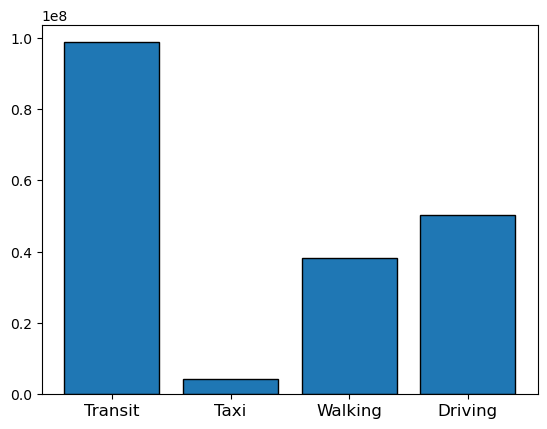

In [6]:
## ridership by mode
byMode = data.groupby(by='tmode', as_index=False).sum()[['tmode', 'ridership']]
plt.bar(np.arange(len(byMode)), list(byMode.ridership), edgecolor = 'black')
plt.xticks([r  for r in range(len(byMode))], ['Transit', 'Taxi',
                                                      'Walking', 'Driving'], fontsize=12)

We use the Multinomial Logit (MNL) as the modeling framework for estimating the mode choice probabilities. MNL is broadly used in transportation choice modeling. It offers an advantage of estimating the mode-choice probabilities using closed-form formulas representing the aggregate-level choices.

the probabilities for each of the four major transportation modes to be chosen as having the highest utility is defined as
$$
\begin{equation}
    P_{mode} = \frac{e^{\lambda U_{mode}}}{e^{\lambda U_{taxi}} + e^{\lambda U_{transit}} + e^{\lambda U_{walk}} + e^{\lambda U_{drive}}}
\end{equation} \ (1)
$$

$\lambda$ being subject to fit.

Additionally, we define the utilily below.

Mathematically, the utility score $U_j$ for alternative ${j}$ depends on the time taken $T_j$ between the O-D pair in consideration and the monetary cost $P_j$ for choosing the alternative, and a random component of error $\epsilon_j$ , yielding a base utility function
$$
\begin{equation}
    U_j = -(CT_j + P_j)
\end{equation}$$

where C is kept as a constant.

The utility can be interpreted as perceived total 'value' of commuting between a o-d pair by the commuter, incorporating possible irrationality of individual decisions while combining it with the direct monetary cost to assess the overall utility. An additional random error term $\epsilon$ can be added to the utility term following a particular distribution. This could be either an additive term or multiplicative term based on our preferences.
Here we will proceed with the additive case, so the utility being defined as $\begin{equation}
    U_j = -(CT_j + P_j) + \epsilon
\end{equation}$


#### Likelihood estimation

From the estimated probabilities $P_m$, we compute the likelihood of the observed LEHD data give the model for each set of $\beta, \sigma$ parameters. For mode choice probabilities $P_m(o,d,\sigma,\beta)$ for each set of origin(o) and destination(d), the log-likelihood for four modes given the observed LEHD ridership $R_m(o,d)$ is calculated as
$$
\begin{equation}
    L(\sigma, \beta) = \sum_{o,d}\sum_m R_m(o,d)\ln P_m(o,d,\sigma,\beta)
\end{equation}
$$


One can simulate the results just for the max-likelihood parameters, however comprehensive parameter sampling provides assessment with respect to the model uncertainty.



In [7]:
# choice for constant C - put as median hourly NYC income (assume all agents are rational and value their time as "face value"; in reality its not always the case and one may consider an additional parameter to scale the objective time value to a subjective estimate)
# our study shows this "rationality" parameter could be as low as 10%!
# NYC median income is ~ $33,220 per year

C = 0.1 * 33220/(12 * 180); C

1.537962962962963

In [8]:
data['U'] = - C * data['duration'] - data['price']

As defined in the utility function, the coefficient C can be interpreted as a parameter incorporating irrationality of decisions based on time and cost.

We use the total number of hours in a day instead of number of working hours to assess the cost of time as people often underestimate the value of time.  So we try a lower bound value (which apparently also provides a better fit to the data). It could be a good idea to fit C as another parameter of the model, but we keep it fixed to make fitting easier for the illustration purposes.

# TASK 1.
Now assume we know just part of the mobility flows, but not all of them (see training sample defined below). Assess the mobility flows with respect to the transportation mode for the reaming pairs of origin-detination locations

In [9]:
#define total number of commutes per origin - detination pair from the ground-truth data (aggregating all the modes together)
ODflows = data[['pulocationid', 'dolocationid', 'ridership']].groupby(['pulocationid', 'dolocationid']).sum(); ODflows.rename(columns = {'ridership': 'total_commute'}, inplace = True); ODflows.head()

total_commute
pulocationid dolocationid               
3            7                       736
             18                    15801
             20                     8418
             24                     7429
             31                      483

In [10]:
data = data.join(ODflows, on = ['pulocationid', 'dolocationid'])

In [11]:
#define the training set
np.random.seed(1)
train_locations = np.random.choice(np.unique(data['pulocationid']), size = 30, replace = False); train_locations.sort()
train_locations

array([  7,  31,  38,  42,  55,  63,  72,  78,  83,  96, 101, 115, 119,
       131, 186, 189, 191, 195, 197, 199, 223, 227, 229, 236, 237, 240,
       254, 256, 260, 263])

In [12]:
#leave only the flows from training set
train_data = data.loc[data['pulocationid'].isin(train_locations) & data['dolocationid'].isin(train_locations)]
test_data = data.loc[~data['pulocationid'].isin(train_locations) & ~data['dolocationid'].isin(train_locations)]

In [13]:
train_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
533,7,83,8,0.299368,6.849358,5704,-7.309774,13731
534,7,83,5,3.913333,0.000000,713,-6.018562,13731
535,7,83,2,0.516667,2.750000,6808,-3.544614,13731
536,7,83,3,0.348206,12.691395,506,-13.226922,13731
555,7,101,3,0.708611,50.000000,23,-51.089818,2852


In [14]:
test_data.head()

,pulocationid,dolocationid,tmode,duration,price,ridership,U,total_commute
2,3,18,3,0.254000,12.900,1748,-13.290643,15801
3,3,18,5,1.084444,0.000,3174,-1.667835,15801
4,3,18,8,0.268923,7.432,10879,-7.845594,15801
5,3,20,5,1.086389,0.000,299,-1.670826,8418
6,3,20,2,0.600000,2.750,4577,-3.672778,8418


## Task 1.1.

Fit the model (1) for different values of $\lambda$ over the given interval (uniform prior) $\lambda \in [0.1, 0.15]$. Sample $\lambda$ with the step 0.00001. Plot the cumulative log-likelihood of the training data as a function of $\lambda$ on this interval. Given the uniform prior, this log-likelihood also serves as a posterior log-likelihood of the $\lambda$ estimate. Report the most likely $\lambda$ from that interval.

Further assess the mean and standard deviation of lambdas (likelihood$^*$-weighted), together with a 99.9\% confidence interval for it.

$^*$ Note that one should distinguish likelihood from log-likelihood. The first is the exp of the second. Also one may compute the relative likelihood $\sim \exp(loglikelihood - max(loglikelihood))$ in order to avoid highly negative exponents making all the likelihood scores computationally indistinguishable from zero.

In [15]:
def calculate_log_likelihoods(lambdas, all_U):
    results = []
    for lambd in lambdas:
        max_U = np.max(lambd * all_U)  # Max of scaled utilities
        log_sum_exp = np.log(np.sum(np.exp(lambd * all_U - max_U)))  # Subtract max_U to stabilize
        log_probs = lambd * all_U - (log_sum_exp + max_U)  # Calculate log-probabilities
        cumulative_log_likelihood = np.sum(log_probs)
        results.append(cumulative_log_likelihood)
    return results

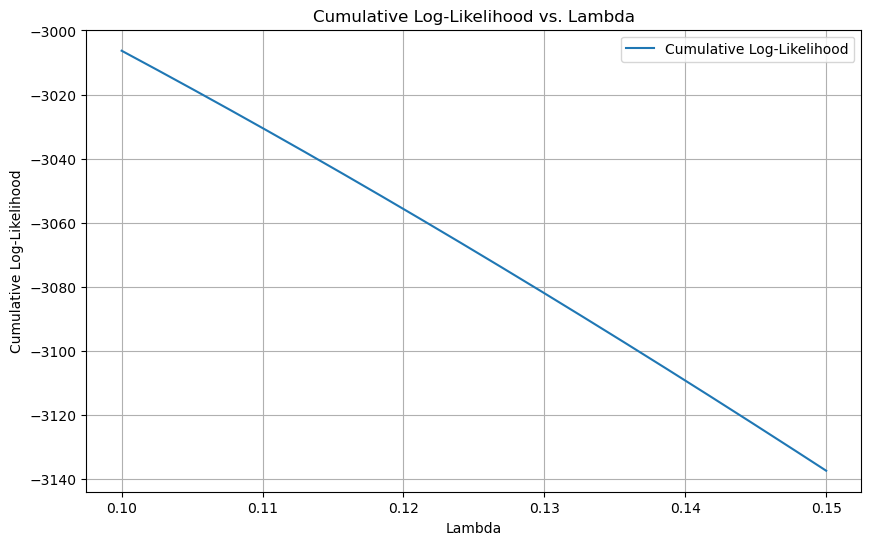

Most likely lambda: 0.10000
Weighted mean lambda: 0.10042
Standard deviation of lambda: 0.00042
99.9% Confidence Interval for Lambda: [0.10002 0.14998]


In [17]:
all_U = train_data['U'].values  
lambdas = np.arange(0.1, 0.15001, 0.00001)

ll = calculate_log_likelihoods(lambdas, all_U)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(lambdas, ll, label='Cumulative Log-Likelihood')
plt.title('Cumulative Log-Likelihood vs. Lambda')
plt.xlabel('Lambda')
plt.ylabel('Cumulative Log-Likelihood')
plt.legend()
plt.grid(True)
plt.show()

max_index = np.argmax(ll)
most_likely_lambda = lambdas[max_index]
print(f"Most likely lambda: {most_likely_lambda:.5f}")

exp_log_likelihoods = np.exp(ll - np.max(ll))
weights = exp_log_likelihoods / np.sum(exp_log_likelihoods)
mean_lambda = np.sum(weights * lambdas)
std_lambda = np.sqrt(np.sum(weights * (lambdas - mean_lambda)**2))

confidence_interval = np.percentile(lambdas, [0.05, 99.95], interpolation='nearest')

print(f"Weighted mean lambda: {mean_lambda:.5f}")
print(f"Standard deviation of lambda: {std_lambda:.5f}")
print(f"99.9% Confidence Interval for Lambda: {confidence_interval}")

## Task 1.2.
Given the posterior likelihood for the $\lambda$ as defined above, assess the model choice prediction over the test set. Run the model for all $\lambda$ from the above range and for all the O-D pairs from the test set compute the likelihood-weighted mean and standard deviation of the model predictions. Record those as "est_ridership_mu" and "est_ridership_std" columns into the test set dataframe, and output the first 20 rows of this dataframe.

In [25]:
all_U = test_data['U'].values 

ll1 = calculate_log_likelihoods(lambdas, all_U)

In [31]:
exp_log_likelihoods = np.exp(ll1 - np.max(ll1))
weights = exp_log_likelihoods / np.sum(exp_log_likelihoods)
mean_lambda = np.sum(weights * lambdas)
std_lambda = np.sqrt(np.sum(weights * (lambdas - mean_lambda)**2))

confidence_interval = np.percentile(lambdas, [0.05, 99.95], interpolation='nearest')

print(f"Weighted mean lambda: {mean_lambda:.5f}")
print(f"Standard deviation of lambda: {std_lambda}")
print(f"99.9% Confidence Interval for Lambda: {confidence_interval}")

Weighted mean lambda: 0.10000
Standard deviation of lambda: 4.914216726168832e-06
99.9% Confidence Interval for Lambda: [0.10002 0.14998]


## Custom Neural Network model for mode-choice probabilities

The Multinomial logit model above is based on having closed form solutions for mode probabilites under certain assumptions about the individual choice factors. However not depending on that allow us to have further flexibility in choosing the modeling framework.

Let's introduce a simulation based approach for individual choice probabilities. Here, for each o-d pair we assess utility based on travel time and cost estimates as well as a random factor, representing individual preferences towards each mode as $U = -(T*C + P) * \epsilon$, where T is the travel time estimate, P is the travel fare/cost estimate and C is the adjustment for hourly income for NYC. The random factor $\epsilon$ is considered to be a random log-normally distributed variable, such that
$$
\epsilon = e^\varepsilon, \varepsilon\sim N(0, \sigma^2)
$$
where $\sigma$ defining the average relative "strength" of the individual choice factors is going to be a parameter of our model.

The mode-choice probabilities are then directly determined by the maximum utilities of 4 modes in question for a given o-d pair.

Unlike the multinomial logit model setting, the model formulation above might not have a closed-form analytic solution for the choice probabilities, so we may need to perform the choice simulations directly. However, performing parameter estimation through simulations might be computationally costly. In order to streamline the computational process, we first implement a neural network (NN) model fitting the mode-choice probabilities between the four transportation mode as the function of their utilities with model parameters.

We'll simulate 50,000 random utilities to fit the NN, with the simulated utilities being the input to get probabilities as the outputs. The model architecture consists of three hidden layers with 8,12,8 neurons respectively, with a rectified linear unit ("relu") activation for hidden and sigmoid for the output layer trained on 'binary cross-entropy' objective function.

We can then use this trained NN model for estimating mode-choice probabilities for the LEHD mobility data (calculating the mode utilities for each o-d) instead of using simulations or explicit analytic formulas.

In [ ]:
! pip install --force-reinstall charset-normalizer==3.1.0
! pip install chardet

from scipy.stats import norm
from keras.losses import KLDivergence
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from numpy import nan

import time

In [ ]:
#simulate sampleN random utility vectors for N modes
def randomUS(N = 4, sampleN = 10000, muU = 0, sigmaU = 1, srange = [0, 1]):
    U = np.random.normal(loc = muU, scale = sigmaU, size = (sampleN, N))
    S = np.random.uniform(low = srange[0], high = srange[1], size = (sampleN, 1))
    return np.concatenate([U, S], axis = 1)

In [ ]:
#generate a random sample of U's and sigma's for further choice probability simulation and neural network training to model those
np.random.seed(1)
sampleN = 100000
US_train = randomUS(N = 4, sampleN = sampleN, muU = train_data['U'].mean(), sigmaU = train_data['U'].std(), srange = [0, 3])

In [ ]:
US_train

In [ ]:
#function simulated choices probabilities
def simChoice(US, N):
    #U - scenarios with utilities n x m array, n - number of scenarios, m - number of choices
    #sigma - random component std
    #N - number of simulations
    n = US.shape[0]; m = US.shape[1] - 1 #number of scenarios choices
    e = np.random.normal(loc = 0, scale = 1, size = (N, n, m)) * US[:, -1].reshape((1, -1, 1))
    Usim = np.exp(e) * US[:, :-1] #simulated utilities
    ch = np.argmax(Usim, axis = 2) #choices
    p = []
    for k in range(m):
      p += [list((ch == k).sum(axis = 0))]
    p = np.array(p).T
    p = p / p.sum(axis = 1, keepdims = True) #choice probabilities
    return p



In [ ]:
#assess the choice probabilities over 10.000 chunks of the training set of U's and sigma's
P_train = np.zeros((sampleN, 4))
for i in range(sampleN // 10000 + 1):
    P_train[(10000 * (i-1)) : (10000 * i), :] = simChoice(US = US_train[(10000 * (i-1)) : (10000 * i), :], N = 1000)

In [ ]:
US_test = randomUS(N = 4, sampleN = 1000, muU = train_data['U'].mean(), sigmaU = train_data['U'].std(), srange = [0, 3])
P_test = simChoice(US = US_test, N = 1000)

## Task 2.1 (extracredit)
Given this training data above (array of simulated utilities and sigmas US_train and the corresponding choice probabilities P_train) train a Neural Network Model with an input layer of 5 neurons (receiving utilities U1,2,3,4 and sigma), 3 hidden layers 10 neurons each, softmax output layer with 4 neurons representing 4 mode choice probabilities, adam optimizer, kullback_leibler_divergence opjective function, 100 epochs, batches of size 100). You may use keras or pytorch.

Apply the model to the test set, compare its output with actual probabilities for the first 10 rows of the training set. Compute the overall KL_divergence and MSE

## Task 2.2(extracredit).
Apply the model to training data from the task 1 for sigma = 1

##Task 2.3 (extracredit)

Try different sigmas (try to pick the proper range). Identify the sigma maximizing the likelihood of the training data. Report it together with likelihood-weighted mean and standard deviation

## Task 2.4(extracredit)

Similar to task 1, run the model over the test data with different sigmas from your prior range, record the resulting likelihood-weighted mean and std into the dataframe, output the first 20 columns